In [1]:
using Pkg
Pkg.activate("../")
Pkg.status()

  Activating environment at `~/WORK/HPL/Code/ina-julia/Project.toml`


      Status `~/WORK/HPL/Code/ina-julia/Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.4
  [a134a8b2] BlackBoxOptim v0.6.0
  [336ed68f] CSV v0.8.5
  [a93c6f00] DataFrames v1.2.2
  [0c46a032] DifferentialEquations v6.18.0
  [7073ff75] IJulia v1.23.2
  [91a5bcdd] Plots v1.21.3
  [c3572dad] Sundials v4.5.3


# Load packages

In [2]:
using DifferentialEquations
using Sundials
using DataFrames: DataFrame
using CSV: File as CSVFile

using Plots
using BenchmarkTools

using Parameters
using Setfield

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1342
┌ Warning: Module StochasticDiffEq with build ID 1184292277534 is missing from the cache.
│ This may mean StochasticDiffEq [789caeaf-c7a9-5a7d-9973-96adeb23e2a0] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = ErrorException("Required dependency DiffEqFinancial [5a0ffddc-d203-54b0-88ba-2c03c0fc2e67] failed to load from a cache file.")
└ @ Base loading.jl:1055
┌ Info: Precompiling MultiScaleArrays [f9640e96-87f6-5992-9c3b-0743c6a49ffa]
└ @ Base loading.jl:1342
┌ Warning: Module StochasticDiffEq with build ID 1184292277534 is missing from the cache.
│ This may mean StochasticDiffEq [789caeaf-c7a9-5a7d-9973-96adeb23e2a0] does not support precompilation but is imported by a 

# Load CSV

In [3]:
dirname_data = "../data"
dirname_legends = joinpath(dirname_data, "legends")
dirname_protocols = joinpath(dirname_data, "protocols")

filename_legend_constants = joinpath(dirname_legends, "legend_constants_v2.csv")
filename_legend_states = joinpath(dirname_legends, "legend_states.csv")
filename_protocol = joinpath(dirname_protocols, "protocol_sparse.csv");

In [4]:
read_csv(filename) = DataFrame(CSVFile(filename))

read_csv (generic function with 1 method)

In [5]:
legend_states = read_csv(filename_legend_states)
legend_constants = read_csv(filename_legend_constants)
protocol = read_csv(filename_protocol);

In [6]:
find_step(t, protocol) = protocol.v[findfirst(x -> x >= t, protocol.t)]

function create_p_from_legend(legend)
    name = Symbol.(legend_constants.name)
    value = legend_constants.value
    p = (; zip(name, value)...)
end

create_p_from_legend (generic function with 1 method)

# Load equations

In [7]:
include("../src/models/ina.jl");
include("../src/models/currents.jl");

# Define model

In [8]:
function compute_algebraic(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
        
    tau_m  = calculate_tau_m(v_m, p)
    tau_h  = calculate_tau_h(v_m, p)
    tau_j  = calculate_tau_j(v_m, p)
    
    m_inf  = calculate_m_inf(v_m, p)
    h_inf  = calculate_h_inf(v_m, p)
    
    v_cp   = calculate_v_cp(v_comp, p)

    I_leak = calculate_I_leak(v_m, p)
    I_Na   = calculate_I_Na(v_m, m, h, j, p)
    I_c    = calculate_I_c(v_m, v_cp, I_leak, I_Na,  p)  # or calculate_I_c(v_m, v_p, I_leak, I_Na,  p)
    I_p    = 0  # or calculate_I_p(v_cp, v_p, p)
    I_comp = calculate_I_comp(v_comp, p)
    
    I_in   = I_leak + I_Na + I_c - I_comp + I_p
    
    a = (;
     tau_m, tau_h, tau_j, m_inf, h_inf,
     v_cp,
     I_leak, I_Na, I_c, I_comp, I_in
    )
    
end

compute_algebraic (generic function with 1 method)

In [9]:
function compute_rates!(du, u, p::NamedTuple, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
    
    a = compute_algebraic(du, u, p, t)
    
    du[1] = calculate_d_v_comp(v_comp, p)  # v_comp
    
    @unpack v_cp, I_leak, I_Na = a
    du[2] = calculate_d_v_p(v_cp, v_p, p)  # v_p
    du[3] = calculate_d_v_m(v_m, v_p, I_leak, I_Na, p)  # v_m
        
    @unpack m_inf, tau_m, h_inf, tau_h, tau_j = a
    du[4] = calculate_d_gate(m_inf, m, tau_m)  # m
    du[5] = calculate_d_gate(h_inf, h, tau_h)  # h
    du[6] = calculate_d_gate(h_inf, j, tau_j)  # j
        
    @unpack I_in = a
    du[7] = calculate_d_I_out(I_in, I_out, p)  # I_out
    
    nothing
end


function compute_rates!(du, u, p::Dict, t)
    compute_rates!(du, u, p["p"], t)
end

compute_rates! (generic function with 2 methods)

In [10]:
rhs = ODEFunction(compute_rates!, syms=[:v_comp, :v_p, :v_m, :m, :h, :j, :I_out]);

# Callbacks

In [11]:
function change_step!(integrator)
    t = integrator.t
    v_c = find_step(t, protocol)
    p = integrator.p["p"]
    k, v = keys(p), collect(values(p))
    v[end] = v_c
    p = NamedTuple(collect(zip(k, v)))
    integrator.p["p"] = p
    set_proposed_dt!(integrator, 1e-9)
    nothing
end


function change_state!(integrator)
    integrator.u = integrator.p["u_eq"]
    nothing 
end

time_trace = [0.25 * k for k in 0: 20]
cb_step  = PresetTimeCallback(protocol.t, change_step!,  save_positions=(false, false))
cb_state = PresetTimeCallback(time_trace, change_state!, save_positions=(false, false))
cb_set = CallbackSet(cb_step, cb_state);

In [ ]:
# function affect!(integrator)
#     t = integrator.t
#     v_c = find_step(t, protocol)
#     p = integrator.p
#     @set p.v_c = v_c
#     integrator.p = p
#     set_proposed_dt!(integrator, 1e-9)
#     nothing
# end

# Solve model

## equilibrium

In [63]:
u₀ = [-80.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0];

In [64]:
reltol = 1e-6
abstol = 1e-3
solver = CVODE_BDF();

In [65]:
tspan_initial = (0., 2.)
p = Dict("p" => create_p_from_legend(legend_constants))
prob_initial = ODEProblem(rhs, u₀, tspan_initial, p);

In [66]:
solve_kwargs = (; reltol, abstol, solver)

sol_initial = solve(prob_initial; solve_kwargs...);

In [17]:
@benchmark solve(prob_initial; solve_kwargs...)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  262.710 μs …  20.919 ms  ┊ GC (min … max): 0.00% … 96.62%
 Time  (median):     327.279 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   418.554 μs ± 563.978 μs  ┊ GC (mean ± σ):  4.27% ±  3.34%

  █▅▄▃▂▅▇▄▃▂▁▁  ▃▂ ▃▃▃▃▄▂▂▁▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁ ▁                  ▂
  ████████████▇████████████████████████████████▇██▇█▆▆▆▆▅▅▅▆▂▄▅ █
  263 μs        Histogram: log(frequency) by time        842 μs <

 Memory estimate: 127.12 KiB, allocs estimate: 1061.

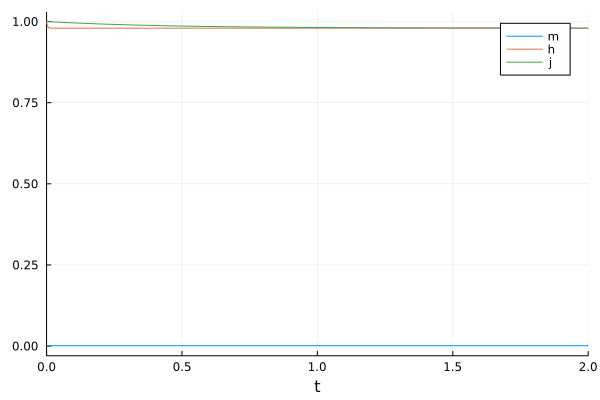

In [18]:
plot(sol_initial, vars=[:m, :h, :j])

## full trace

In [19]:
tspan = (0., 5.)
p = create_p_from_legend(legend_constants)
u_eq = copy(sol_initial.u[end])
p = Dict("p" => create_p_from_legend(legend_constants),
         "u_eq" => u_eq)
prob = ODEProblem(rhs, u_eq, tspan, p, callback=cb_set)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 5.0)
u0: 7-element Vector{Float64}:
 -80.0
 -80.0
 -81.02720638168518
   0.0010376057044023433
   0.9796438499338762
   0.9798558630824812
 -38.99477240203509

In [20]:
saveat = tspan[1]: 5e-5: tspan[2]

solve_kwargs = (; reltol, abstol, solver, saveat)

sol = solve(prob; solve_kwargs...);

In [21]:
@benchmark solve(prob; solve_kwargs...)

BenchmarkTools.Trial: 14 samples with 1 evaluation.
 Range (min … max):  327.891 ms … 483.558 ms  ┊ GC (min … max): 16.53% … 23.26%
 Time  (median):     356.262 ms               ┊ GC (median):    18.56%
 Time  (mean ± σ):   383.122 ms ±  53.112 ms  ┊ GC (mean ± σ):  18.36% ±  2.77%

  █   █  ▁▁▁  ▁                 ▁ ▁  █                      ▁ ▁  
  █▁▁▁█▁▁███▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█ ▁
  328 ms           Histogram: frequency by time          484 ms <

 Memory estimate: 394.74 MiB, allocs estimate: 717983.

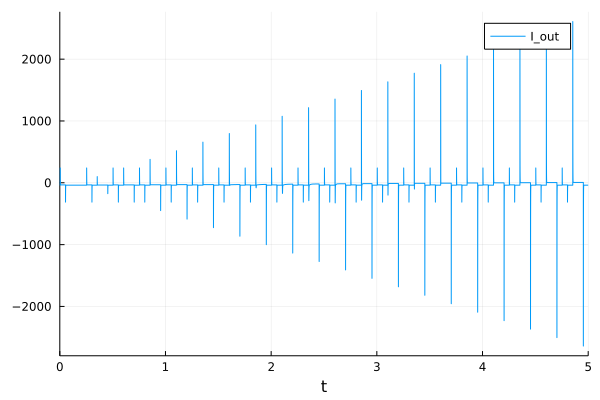

In [22]:
plot(sol, vars=[:I_out])

# ModelingToolkit

In [23]:
using ModelingToolkit

In [25]:
p = create_p_from_legend(legend_constants)
prob = ODEProblem(rhs, u_eq, tspan, p, callback=cb_set)
de = modelingtoolkitize(prob);
de_simplified = structural_simplify(de)

In [26]:
de_simplified

Model ##MTKizedODE#3114 with 7 equations
States (7):
  x₁(t) [defaults to -80.0]
  x₂(t) [defaults to -80.0]
  x₃(t) [defaults to -81.0272]
  x₄(t) [defaults to 0.0010376]
  x₅(t) [defaults to 0.979641]
  x₆(t) [defaults to 0.0969821]
⋮
Parameters (30):
  c_p [defaults to 4.50296e-12]
  c_m [defaults to 2.47302e-11]
  a0_m [defaults to 16529.1]
  b0_m [defaults to 386.7]
  delta_m [defaults to 22.823]
  s_m [defaults to 12.8321]
⋮
Incidence matrix:
 ×  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ×  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ×  ⋅  ⋅  ⋅  ⋅  ⋅  ×  ×  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ×  ⋅  ⋅  ⋅  ⋅  ⋅  ×  ×  ×  ×  ×  ⋅
 ⋅  ⋅  ⋅  ×  ⋅  ⋅  ⋅  ⋅  ⋅  ×  ×  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ×  ⋅  ⋅  ⋅  ⋅  ×  ⋅  ×  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ×  ⋅  ⋅  ⋅  ×  ⋅  ⋅  ×  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ×  ×  ⋅  ×  ×  ×  ×  ×

In [27]:
jac = eval(ModelingToolkit.generate_jacobian(de_simplified)[2]);

In [37]:
tspan = (0., 5.)
p = create_p_from_legend(legend_constants)
u_eq = copy(sol_initial.u[end])
p = Dict("p" => create_p_from_legend(legend_constants),
         "u_eq" => u_eq)

Dict{String, Any} with 2 entries:
  "u_eq" => [-80.0, -80.0, -81.0272, 0.00103761, 0.979644, 0.979856, -38.9948]
  "p"    => (c_p = 4.50296e-12, c_m = 2.47302e-11, a0_m = 16529.1, b0_m = 386.7…

In [30]:
prob = ODEProblem(rhs, u_eq, tspan, p, callback=cb_step)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 5.0)
u0: 7-element Vector{Float64}:
 -80.0
 -80.0
 -81.02720638168518
   0.0010376057044023433
   0.9796438499338762
   0.9798558630824812
 -38.99477240203509

In [32]:
solve_kwargs = (; reltol, abstol, solver, saveat)

sol = solve(prob; solve_kwargs...);

In [33]:
@benchmark solve(prob; solve_kwargs...)

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  174.662 ms … 331.161 ms  ┊ GC (min … max): 12.54% … 20.70%
 Time  (median):     191.074 ms               ┊ GC (median):    12.07%
 Time  (mean ± σ):   206.916 ms ±  43.975 ms  ┊ GC (mean ± σ):  12.35% ±  3.17%

  ▄█                                                             
  ██▁▁▁▁▆▄▁▁▄▄▁▁▁▁▁▁▁▄█▁▁▁▁▁▁▁▁▁▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▄ ▁
  175 ms           Histogram: frequency by time          331 ms <

 Memory estimate: 138.62 MiB, allocs estimate: 519598.

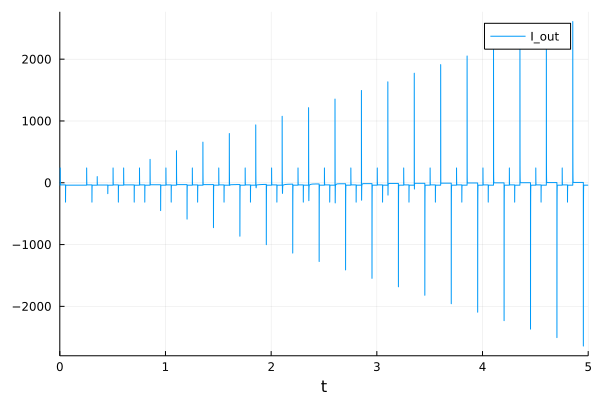

In [34]:
plot(sol, vars=[:I_out])

In [73]:
# all callbacks

p = create_p_from_legend(legend_constants)
u_eq = copy(sol_initial.u[end])
p = Dict("p" => create_p_from_legend(legend_constants),
         "u_eq" => u_eq)
prob = ODEProblem(rhs, u_eq, tspan, p, callback=cb_set)
solve_kwargs = (; reltol, abstol, solver, saveat)
sol = solve(prob; solve_kwargs...);

In [74]:
@benchmark solve(prob; solve_kwargs...)

BenchmarkTools.Trial: 12 samples with 1 evaluation.
 Range (min … max):  359.073 ms … 619.905 ms  ┊ GC (min … max): 11.87% … 15.82%
 Time  (median):     410.769 ms               ┊ GC (median):    19.53%
 Time  (mean ± σ):   439.086 ms ±  78.108 ms  ┊ GC (mean ± σ):  17.14% ±  3.18%

  ▁    ▁ █ ▁ ▁▁ ▁▁                      ▁  ▁                  ▁  
  █▁▁▁▁█▁█▁█▁██▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  359 ms           Histogram: frequency by time          620 ms <

 Memory estimate: 394.74 MiB, allocs estimate: 717983.